In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
TF_ENABLE_GPU_GARBAGE_COLLECTION=False

In [4]:
image_dir_train = Path('C:\\ML Projects\\BrainTumourDataset\\TransformedImages(RadonTransform)\\Combination11(Cosine&Hamming&Hann&Rmp&Shepp-Logan)')
image_dir_test = Path('C:\\ML Projects\\BrainTumourDataset\\Dataset\\Testing')

In [5]:
filepaths_train = list(image_dir_train.glob(r'**/*.jpg'))
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_train))



filepaths_train = pd.Series(filepaths_train, name='Filepath').astype(str)
labels_test = pd.Series(labels_test, name='Label')

images_train = pd.concat([filepaths_train, labels_test], axis=1)
images_train.to_csv('C:\\ML Projects\\BrainTumourDataset\\Combination11(Cosine&Hamming&Hann&Rmp&Shepp-Logan).csv')

In [12]:
filepaths_test = list(image_dir_test.glob(r'**/*.jpg'))
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_test))



filepaths_test = pd.Series(filepaths_test, name='Filepath').astype(str)
labels_test = pd.Series(labels_test, name='Label')

images_test = pd.concat([filepaths_test, labels_test], axis=1)
images_test.to_csv('C:\\ML Projects\\BrainTumourDataset\\Test.csv')

In [6]:
[os.path.abspath(filepaths_train[0]) for filepaths_train[0] in filepaths_train ]
print(len(filepaths_train))

27930


In [7]:
images_train.Label.value_counts()

notumor       7975
pituitary     7285
meningioma    6675
glioma        5995
Name: Label, dtype: int64

In [8]:
images_train

,Filepath,Label
0,C:\ML Projects\BrainTumourDataset\TransformedI...,glioma
1,C:\ML Projects\BrainTumourDataset\TransformedI...,glioma
2,C:\ML Projects\BrainTumourDataset\TransformedI...,glioma
3,C:\ML Projects\BrainTumourDataset\TransformedI...,glioma
4,C:\ML Projects\BrainTumourDataset\TransformedI...,glioma
...,...,...
27925,C:\ML Projects\BrainTumourDataset\TransformedI...,pituitary
27926,C:\ML Projects\BrainTumourDataset\TransformedI...,pituitary
27927,C:\ML Projects\BrainTumourDataset\TransformedI...,pituitary
27928,C:\ML Projects\BrainTumourDataset\TransformedI...,pituitary


In [9]:
train_df, test_df = train_test_split(images_train, train_size=0.8, shuffle=True, random_state=1)

In [24]:
[os.path.abspath(filepaths_test[0]) for filepaths_test[0] in filepaths_test ]
print(len(filepaths_test))

1311


In [25]:
images_test.Label.value_counts()

notumor       405
meningioma    306
glioma        300
pituitary     300
Name: Label, dtype: int64

In [26]:
images_test

,Filepath,Label
0,C:\ML Projects\BrainTumourDataset\Dataset\Test...,glioma
1,C:\ML Projects\BrainTumourDataset\Dataset\Test...,glioma
2,C:\ML Projects\BrainTumourDataset\Dataset\Test...,glioma
3,C:\ML Projects\BrainTumourDataset\Dataset\Test...,glioma
4,C:\ML Projects\BrainTumourDataset\Dataset\Test...,glioma
...,...,...
1306,C:\ML Projects\BrainTumourDataset\Dataset\Test...,pituitary
1307,C:\ML Projects\BrainTumourDataset\Dataset\Test...,pituitary
1308,C:\ML Projects\BrainTumourDataset\Dataset\Test...,pituitary
1309,C:\ML Projects\BrainTumourDataset\Dataset\Test...,pituitary


In [27]:
test_df = images_test

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,validation_split=0.1)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [11]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df,x_col='Filepath',y_col='Label',target_size=(224, 224),color_mode='rgb',class_mode='categorical',batch_size=10,shuffle=True,seed=42,subset='training')

val_images = train_generator.flow_from_dataframe(dataframe=train_df,x_col='Filepath',y_col='Label',target_size=(224, 224),color_mode='rgb',class_mode='categorical',batch_size=10,shuffle=True,seed=42,subset='validation')

test_images = test_generator.flow_from_dataframe(dataframe=test_df,x_col='Filepath',y_col='Label',target_size=(224, 224),color_mode='rgb',class_mode='categorical',batch_size=10,shuffle=False)

Found 20110 validated image filenames belonging to 4 classes.
Found 2234 validated image filenames belonging to 4 classes.
Found 5586 validated image filenames belonging to 4 classes.


In [12]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(input_shape=(224, 224, 3),include_top=False,weights='imagenet',pooling='avg')

pretrained_model.trainable = False

In [13]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [16]:
history = model.fit(train_images,validation_data=val_images,epochs=50)#,callbacks=callbacks)

Epoch 1/50
2011/2011 [==============================] - 226s 109ms/step - loss: 0.3070 - accuracy: 0.8857 - val_loss: 0.1998 - val_accuracy: 0.9257
Epoch 2/50
2011/2011 [==============================] - 217s 108ms/step - loss: 0.1601 - accuracy: 0.9419 - val_loss: 0.2268 - val_accuracy: 0.9235
Epoch 3/50
2011/2011 [==============================] - 217s 108ms/step - loss: 0.1165 - accuracy: 0.9590 - val_loss: 0.0754 - val_accuracy: 0.9691
Epoch 4/50
2011/2011 [==============================] - 217s 108ms/step - loss: 0.0833 - accuracy: 0.9695 - val_loss: 0.0925 - val_accuracy: 0.9772
Epoch 5/50
2011/2011 [==============================] - 217s 108ms/step - loss: 0.0614 - accuracy: 0.9774 - val_loss: 0.0690 - val_accuracy: 0.9763
Epoch 6/50
2011/2011 [==============================] - 217s 108ms/step - loss: 0.0502 - accuracy: 0.9824 - val_loss: 0.0830 - val_accuracy: 0.9718
Epoch 7/50
2011/2011 [==============================] - 216s 108ms/step - loss: 0.0514 - accuracy: 0.9822 - val_

In [20]:
model.save('C:\\ML Projects\\BrainTumourDataset\\ResNet50_Model_RadonTransform(Combination9(Cosine&Hamming&Shepp-Logan&Hann))_Weights.h5')

c:\Users\Asus\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [22]:
new_model = tf.keras.models.load_model('C:\\ML Projects\\BrainTumourDataset\\ResNet50_Model_RadonTransform(Combination10(Hamming&Shepp-Logan&Hann&Ramp))_Weights.h5')

In [23]:
results = new_model.evaluate(test_images, verbose=1)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

559/559 [==============================] - 59s 103ms/step - loss: 0.0045 - accuracy: 0.9982
[0.004501463379710913, 0.9982098340988159]
Test Accuracy: 99.82%


In [24]:
prediction_probability = new_model.predict(test_images)
predictions = np.argmax(new_model.predict(test_images), axis=1)
matrix = confusion_matrix(test_images.labels, predictions)
report= classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

<Axes: >

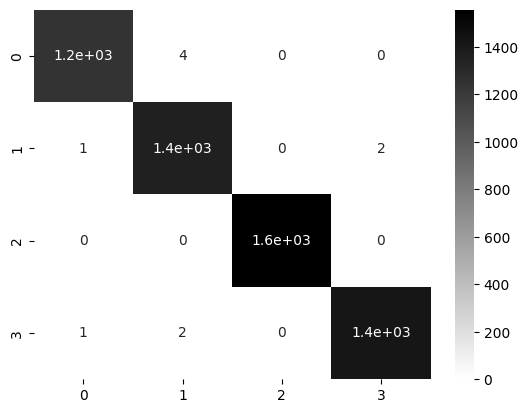

In [25]:
import seaborn as sns
sns.heatmap(matrix, annot=True, cmap='binary')

In [21]:
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.99      0.99      1244
  meningioma       0.99      0.99      0.99      1361
     notumor       1.00      1.00      1.00      1556
   pituitary       1.00      1.00      1.00      1425

    accuracy                           1.00      5586
   macro avg       1.00      1.00      1.00      5586
weighted avg       1.00      1.00      1.00      5586



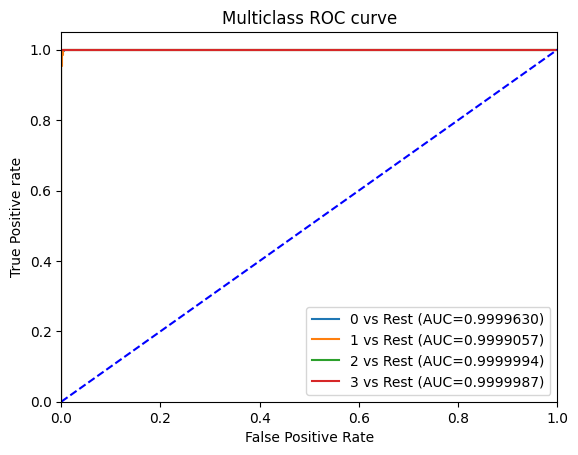

In [22]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve,auc
#binarize the y_values

y_test_binarized=label_binarize(test_images.labels,classes=np.unique(test_images.labels))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

classes=np.unique(test_images.labels)
n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], prediction_probability[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='-', 
             label='%s vs Rest (AUC=%0.7f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [17]:
data_his = pd.DataFrame(history.history)
data_his

,loss,accuracy,val_loss,val_accuracy
0,3.069594e-01,0.885728,1.998361e-01,0.925694
1,1.601107e-01,0.941870,2.267800e-01,0.923456
2,1.164862e-01,0.958976,7.536342e-02,0.969114
3,8.334631e-02,0.969518,9.248900e-02,0.977171
4,6.140391e-02,0.977374,6.901196e-02,0.976276
5,5.019296e-02,0.982447,8.295834e-02,0.971799
6,5.136784e-02,0.982198,2.727522e-02,0.990600
7,4.416623e-02,0.985977,3.234208e-02,0.988809
8,3.885217e-02,0.988364,5.056377e-02,0.981647
9,3.073276e-02,0.990453,2.753033e-02,0.989257


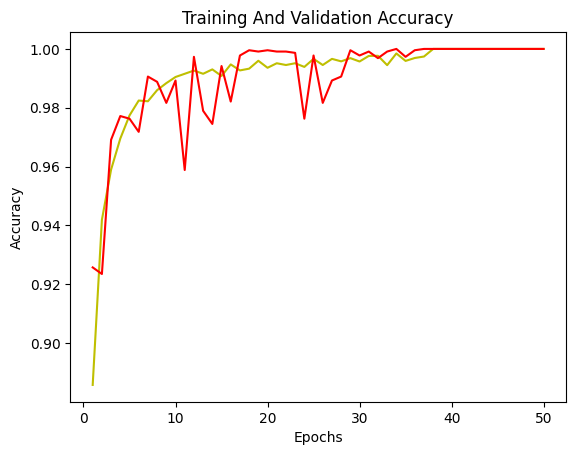

In [18]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Training Accuracy')
plt.title('Training And Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

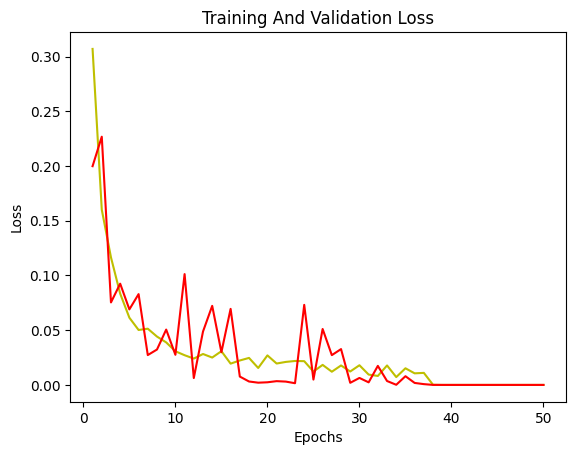

In [19]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training And Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [4]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [5]:
from sklearn.model_selection import KFold, StratifiedKFold

train_data = pd.read_csv('C:\\ML Projects\\BrainTumourDataset\\Combination9(Cosine&Hamming&Shepp-Logan&Hann).csv')
Y = train_data[['Label']]
X = train_data[['Filepath']]

kf = KFold(n_splits = 5)
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

In [6]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)


In [7]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [8]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = 'K-Fold_Cross_Validation_Models'
fold_var = 1
image_dir = 'C:\\ML Projects\\BrainTumourDataset\\TransformedImages(RadonTransform)\\Combination9(Cosine&Hamming&Shepp-Logan&Hann)'

for train_index, val_index in skf.split(X,Y):
	training_data = train_data.iloc[train_index]
	validation_data = train_data.iloc[val_index]
	
	train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,x_col = "Filepath", y_col = "Label",class_mode = "categorical", target_size=(224, 224),color_mode='rgb',batch_size=10,shuffle = True)
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,x_col = "Filepath", y_col = "Label",class_mode = "categorical",target_size=(224, 224),color_mode='rgb',batch_size=10, shuffle = True)

	
    #DEFINE MODEL
	pretrained_model = tf.keras.applications.resnet50.ResNet50(input_shape=(224, 224, 3),include_top=False,weights='imagenet',pooling='avg')
	pretrained_model.trainable = False
	inputs = pretrained_model.input
	inputs = pretrained_model.input
	inputs = pretrained_model.input
	x = tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)
	x = tf.keras.layers.Dense(256, activation='relu')(x)
	x = tf.keras.layers.Dense(128, activation='relu')(x)
	outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
	model = tf.keras.Model(inputs, outputs)
    
    
	
	

    
	# COMPILE NEW MODEL
	model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
	
	# CREATE CALLBACKS
	checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
	callbacks_list = [checkpoint]

	# FIT THE MODEL
	history = model.fit(train_data_generator,epochs=15,callbacks=callbacks_list,validation_data=valid_data_generator)

	
	# LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights(save_dir+str(get_model_name(fold_var)))
	
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDATION_LOSS.append(results['loss'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Found 17875 validated image filenames belonging to 4 classes.
Found 4469 validated image filenames belonging to 4 classes.
Epoch 1/15
1788/1788 [==============================] - 230s 124ms/step - loss: 0.3140 - accuracy: 0.8804 - val_loss: 0.1906 - val_accuracy: 0.9311

Epoch 00001: val_accuracy improved from -inf to 0.93108, saving model to K-Fold_Cross_Validation_Modelsmodel_1.h5


c:\Users\Asus\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/15
1788/1788 [==============================] - 215s 120ms/step - loss: 0.1711 - accuracy: 0.9376 - val_loss: 0.1142 - val_accuracy: 0.9599

Epoch 00002: val_accuracy improved from 0.93108 to 0.95995, saving model to K-Fold_Cross_Validation_Modelsmodel_1.h5
Epoch 3/15
1788/1788 [==============================] - 214s 120ms/step - loss: 0.1181 - accuracy: 0.9582 - val_loss: 0.0795 - val_accuracy: 0.9738

Epoch 00003: val_accuracy improved from 0.95995 to 0.97382, saving model to K-Fold_Cross_Validation_Modelsmodel_1.h5
Epoch 4/15
1788/1788 [==============================] - 214s 120ms/step - loss: 0.0921 - accuracy: 0.9660 - val_loss: 0.0930 - val_accuracy: 0.9676

Epoch 00004: val_accuracy did not improve from 0.97382
Epoch 5/15
1788/1788 [==============================] - 214s 119ms/step - loss: 0.0742 - accuracy: 0.9754 - val_loss: 0.1566 - val_accuracy: 0.9602

Epoch 00005: val_accuracy did not improve from 0.97382
Epoch 6/15
1788/1788 [==============================] - 214s

c:\Users\Asus\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/15
1788/1788 [==============================] - 213s 119ms/step - loss: 0.1733 - accuracy: 0.9346 - val_loss: 0.1557 - val_accuracy: 0.9452

Epoch 00002: val_accuracy improved from 0.94026 to 0.94518, saving model to K-Fold_Cross_Validation_Modelsmodel_2.h5
Epoch 3/15
1788/1788 [==============================] - 213s 119ms/step - loss: 0.1230 - accuracy: 0.9556 - val_loss: 0.1048 - val_accuracy: 0.9597

Epoch 00003: val_accuracy improved from 0.94518 to 0.95972, saving model to K-Fold_Cross_Validation_Modelsmodel_2.h5
Epoch 4/15
1788/1788 [==============================] - 213s 119ms/step - loss: 0.0845 - accuracy: 0.9680 - val_loss: 0.0553 - val_accuracy: 0.9812

Epoch 00004: val_accuracy improved from 0.95972 to 0.98120, saving model to K-Fold_Cross_Validation_Modelsmodel_2.h5
Epoch 5/15
1788/1788 [==============================] - 213s 119ms/step - loss: 0.0821 - accuracy: 0.9714 - val_loss: 0.0502 - val_accuracy: 0.9819

Epoch 00005: val_accuracy improved from 0.98120 to 0.

c:\Users\Asus\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/15
1788/1788 [==============================] - 212s 119ms/step - loss: 0.1670 - accuracy: 0.9397 - val_loss: 0.1169 - val_accuracy: 0.9591

Epoch 00002: val_accuracy improved from 0.94406 to 0.95905, saving model to K-Fold_Cross_Validation_Modelsmodel_3.h5
Epoch 3/15
1788/1788 [==============================] - 212s 119ms/step - loss: 0.1176 - accuracy: 0.9567 - val_loss: 0.0887 - val_accuracy: 0.9709

Epoch 00003: val_accuracy improved from 0.95905 to 0.97091, saving model to K-Fold_Cross_Validation_Modelsmodel_3.h5
Epoch 4/15
1788/1788 [==============================] - 212s 119ms/step - loss: 0.0856 - accuracy: 0.9682 - val_loss: 0.0578 - val_accuracy: 0.9790

Epoch 00004: val_accuracy improved from 0.97091 to 0.97897, saving model to K-Fold_Cross_Validation_Modelsmodel_3.h5
Epoch 5/15
1788/1788 [==============================] - 212s 119ms/step - loss: 0.0717 - accuracy: 0.9744 - val_loss: 0.0623 - val_accuracy: 0.9783

Epoch 00005: val_accuracy did not improve from 0.9789

c:\Users\Asus\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/15
1788/1788 [==============================] - 211s 118ms/step - loss: 0.1718 - accuracy: 0.9375 - val_loss: 0.1198 - val_accuracy: 0.9608

Epoch 00002: val_accuracy improved from 0.93198 to 0.96084, saving model to K-Fold_Cross_Validation_Modelsmodel_4.h5
Epoch 3/15
1788/1788 [==============================] - 211s 118ms/step - loss: 0.1200 - accuracy: 0.9575 - val_loss: 0.0809 - val_accuracy: 0.9707

Epoch 00003: val_accuracy improved from 0.96084 to 0.97069, saving model to K-Fold_Cross_Validation_Modelsmodel_4.h5
Epoch 4/15
1788/1788 [==============================] - 211s 118ms/step - loss: 0.0915 - accuracy: 0.9673 - val_loss: 0.1429 - val_accuracy: 0.9517

Epoch 00004: val_accuracy did not improve from 0.97069
Epoch 5/15
1788/1788 [==============================] - 210s 118ms/step - loss: 0.0696 - accuracy: 0.9753 - val_loss: 0.0625 - val_accuracy: 0.9767

Epoch 00005: val_accuracy improved from 0.97069 to 0.97673, saving model to K-Fold_Cross_Validation_Modelsmodel_4.h

c:\Users\Asus\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/15
1788/1788 [==============================] - 212s 118ms/step - loss: 0.1735 - accuracy: 0.9371 - val_loss: 0.0982 - val_accuracy: 0.9658

Epoch 00002: val_accuracy improved from 0.91406 to 0.96576, saving model to K-Fold_Cross_Validation_Modelsmodel_5.h5
Epoch 3/15
1788/1788 [==============================] - 212s 119ms/step - loss: 0.1195 - accuracy: 0.9575 - val_loss: 0.1244 - val_accuracy: 0.9521

Epoch 00003: val_accuracy did not improve from 0.96576
Epoch 4/15
1788/1788 [==============================] - 212s 119ms/step - loss: 0.0949 - accuracy: 0.9652 - val_loss: 0.0611 - val_accuracy: 0.9752

Epoch 00004: val_accuracy improved from 0.96576 to 0.97516, saving model to K-Fold_Cross_Validation_Modelsmodel_5.h5
Epoch 5/15
1788/1788 [==============================] - 212s 118ms/step - loss: 0.0738 - accuracy: 0.9747 - val_loss: 0.0399 - val_accuracy: 0.9841

Epoch 00005: val_accuracy improved from 0.97516 to 0.98411, saving model to K-Fold_Cross_Validation_Modelsmodel_5.h

In [9]:
print(VALIDATION_ACCURACY)
print(VALIDATION_LOSS)

[0.9939583539962769, 0.9984336495399475, 0.9979861378669739, 0.9910494685173035, 0.9979856610298157]
[0.04126614332199097, 0.0057363929226994514, 0.009522362612187862, 0.022594591602683067, 0.010750487446784973]
